# Lent Practical 5: Adding Carbon

In this practical, you will add carbon chemistry to the 3 box ocean you created in the last practical. This will allow you to simulate the 'Solubility Pump' that you saw in Lecture 36.

This will involve:
 - Adding two new state variables, DIC and TA, to the model
 - Calculating the state of the carbon chemistry equilibrium in each box.
 - Adding a new 'Atmosphere' box to the model, which contains CO<sub>2</sub>
 - Parameterising the exchange of CO<sub>2</sub> between the atmosphere and the surface ocean boxes

## Packages

As usual, you'll have to run the cell below to install a few packages that we'll use in this practical. One to notice here is `cbsyst`, which is a package for calculating the speciation of DIC in seawater. Before we get to modelling, we'll spend a moment understanding how this package works.

In [ ]:
# This code installs some required packages for the rest of the notebook. Run this once at the start - it should take <30 seconds to run.

%%capture
import os
if not os.path.exists('./OceanTools'):
    !git clone https://github.com/Quantitative-Environmental-Science/OceanTools.git

import sys
sys.path.append('./OceanTools')

!pip install cbsyst

import numpy as np
import matplotlib.pyplot as plt
from cbsyst import Csys  # this is for carbon chemistry calculations

## Carbon Speciation

To calculate carbon speciation we will use the `Csys` function within `cbsyst`. You need to give this function four things:
- The temperature (`T_in`) and salinity (`S_in`) of the water so that it can calculate the *K* values for the carbon species
- *Two* of the quantities that define the carbon system: pH, DIC, TA, HCO<sub>3</sub><sup>-</sup>, CO<sub>3</sub><sup>2-</sup>, CO<sub>2</sub><sup>*</sup> or pCO<sub>2</sub>.

The `cbsyst` package will then use these values to calculate the other parts of the carbon system, and return a dictionary containing all parts of the carbon system and the *K* values used to calculate them.

The code in the cell below provides an example of how to use `cbsyst` to calculate the carbon speciation in seawater. Run it so you can see the output.

> **Note**: By default, `cbsyst` expects all concentrations to be in μmol/kg, and pCO2 in ppm.

In [ ]:
Csys(TA=2400, pCO2=420, T_in=16, S_in=25)

{'pHtot': array([8.08180524]),
 'DIC': array([2214.65507323]),
 'TA': array([2400.]),
 'CO2': array([16.08282603]),
 'HCO3': array([2050.48287188]),
 'CO3': array([148.08937532]),
 'pCO2': np.float64(420.0),
 'fCO2': np.float64(418.50241815644534),
 'BT': array([296.92857143]),
 'Ca': array([0.0102821]),
 'Mg': array([0.0528171]),
 'T_in': array([16]),
 'T_out': None,
 'S_in': array([25]),
 'S_out': None,
 'P_in': None,
 'P_out': None,
 'PT': np.float64(0.0),
 'SiT': np.float64(0.0),
 'ST': 0.02016816723775723,
 'FT': 4.880314366321079e-05,
 'pHsws': array([8.07378851]),
 'pHfree': array([8.15024141]),
 'pHNBS': array([8.21197465]),
 'unit': 1000000.0,
 'Ks': {'K0': np.float64(0.038429469772223286),
  'K1': np.float64(1.0560598863602115e-06),
  'K2': np.float64(5.982221923532746e-10),
  'KW': np.float64(2.1755584779440388e-14),
  'KB': np.float64(1.7063738285272364e-09),
  'KS': np.float64(0.11816740778417133),
  'KspA': np.float64(4.6361826840695887e-07),
  'KspC': np.float64(2.892636

You can see that there's a lot more in the result than just the DIC species... this is why we skipped over the detail of alkalinity. Remember the $[...]$ in the definition of TA?

$$
TA = [HCO_3^-] + 2[CO_3^{2-}] + [...] - [H^+]
$$

That $[...]$ is all the extra stuff you see in the output of `cbsyst`. We can keep ignoring it for the whole of QES, but just be aware that it's there... lurking...

The useful outputs to notice in the list above are: `pHtot`, `CO3`, `HCO3`, `pCO2`, `OmegaA` and `OmegaC`. These are more relevant to the modelling exercise we're about to do.

What else can we do with carbon chemistry? Well, `cbsyst` was used to make all the figures of the carbon system that you saw in lectures. For example, we can make the DIC speciation plot as a function of pH:

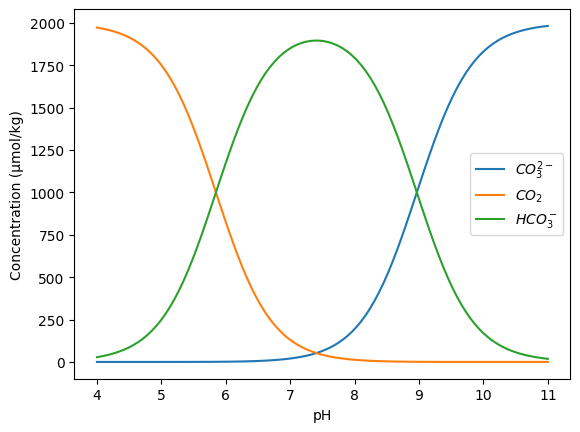

In [ ]:
sw = Csys(DIC=2000, pHtot=np.linspace(4, 11, 100))

plt.plot(sw['pHtot'], sw['CO3'], label='$CO_3^{2-}$')
# add the two other carbon species to the plot here
plt.plot(sw['pHtot'], sw['CO2'], label='$CO_2$')
plt.plot(sw['pHtot'], sw['HCO3'], label='$HCO_3^-$')


plt.xlabel('pH')
plt.ylabel('Concentration (μmol/kg)')

plt.legend()

## 3 Box Ocean - Adding Carbon Chemistry

Now you've got a handle on calculating carbon speciation, we'll add carbon to the model.

The first step is to add two new state variables, DIC and TA, to the model. These will be transported around the ocean in the same way as temperature and salinity, and together set the concentration and speciation of carbon in each box.

### TA

The distribution of TA is determined entirely by circulation and mixing fluxes:

$$
\begin{align*}
\mathrm{\frac{dTA_L}{dt}} &= \mathrm{\left. \left(Q (TA_D - TA_L) - \frac{V_L}{\tau_L} (TA_L - TA_D) \right) \middle/ V_L \right. } \\
\mathrm{\frac{dTA_H}{dt}} &= \mathrm{\left. \left(Q (TA_L - TA_H) - \frac{V_H}{\tau_H} (TA_H - TA_D) \right) \middle/ V_H \right. } \\
\mathrm{\frac{dTA_D}{dt}} &= \mathrm{\left. \left(Q (TA_H - TA_D) - \frac{V_L}{\tau_L} (TA_D - TA_L) - \frac{V_H}{\tau_H} (TA_D - TA_H) \right) \middle/ V_D \right. } \\
\end{align*}
$$

> **Note**: The form of these equations is identical to the temperature and salinity equations, but with the substitution of $TA$ for $T$ or $S$. Because of how you were looping through variables in the model code last practical, it will be *very* straightforward to add TA to the model!

### DIC

DIC is a bit more complex, because we have to consider exchange with the atmosphere.

As with many other processes in this model, we will parameterise $CO_2$ exchange with a characteristic a timescale $\tau_{CO2}$, which describes the time over which the surface box will equilibrate with the overlying atmosphere.
We can therefore write the exchange of $CO_2$ between a surface box and the atmosphere as:

$$
\mathrm{\frac{d[DIC]_{CO2ex}}{dt} = \frac{V}{\tau_{CO2}} ([CO_2]_{SW} - K_0 pCO_2 \rho \times 10^{-6})}
$$

Where:
 - $pCO_2$ is the partial pressure of $CO_2$ in the overlying atmosphere in ppm
 - $K_0$ is the Henry's law constant that calculates the $[CO_2]$ concentration (in μmol kg<sup>-1</sup>) at a given ppm $pCO_2$ (recall that $[CO_2] = K_0 pCO_2$).
 - the factor of $\times 10^{-6}$ converts the units of $[CO_2]$ from μmol to mol, and seawater density, $\rho$, is approximately 1000 kg m<sup>-3</sup>.

Including this alongside our transport terms gives us:

$$
\begin{align*}
\mathrm{\frac{d[DIC]_L}{dt}} &= \mathrm{\left. \left(Q ([DIC]_D - [DIC]_L) - \frac{V_L}{\tau_L} ([DIC]_L - [DIC]_D) - \frac{V_L}{\tau_{CO2}} ([CO_2]_L - K_{0,L} ~ pCO2_A ~ \rho_L  \times 10^{-6}) \right) \middle/ V_L \right.} \\
\mathrm{\frac{d[DIC]_H}{dt}} &= \mathrm{\left. \left(Q ([DIC]_L - [DIC]_H) - \frac{V_H}{\tau_H} ([DIC]_H - [DIC]_D) - \frac{V_H}{\tau_{CO2}} ([CO_2]_H - K_{0,H} ~ pCO2_A ~ \rho_H  \times 10^{-6}) \right) \middle/ V_H \right.} \\
\end{align*}
$$

> **Note**: The deep ocean DIC equation is only the transport terms, as it does not interact with the atmosphere.

### Atmospheric $CO_2$

Finally, we need an equation to calculate how $pCO2$ will change in the atmosphere:

$$
\mathrm{\frac{d~pCO_2}{dt} = \left. \left( \frac{V_L}{\tau_{CO2}} ([CO_2]_L - K_{0,L} ~ pCO2_A ~ \rho_L  \times 10^{-6}) + \frac{V_H}{\tau_{CO2}} ([CO_2]_H - K_{0,H} ~ pCO2_A ~ \rho_H  \times 10^{-6}) \right) \times 10^6 \middle/ n_A \right.}
$$

where $n_A$ is the total moles of air in the atmosphere.

### $CO_2$ Emissions

The final factor we can consider here is emitting $CO_2$ into the atmosphere.
To do this, we can add a given amount of carbon to our atmosphere box in each model timestep, and let it equilibrate with the ocean.
For example, if we emit 8 PgC in a year:
$$
n_{C-atmos}^{i+1} = n_{C-atmos}^{i} + 8\times10^{15}~/~ 12
$$
Where the factor of 12 converts from g to moles of $C$.


## Model Setup

### Global Variables
The cell below contains a number of key variables that you will use to construct a three-box model of ocean circulation driven by changes in air temperature and salinity inputs.

> **Note**: These global variables are identical to the last practical

In [ ]:
# global variables
V_ocean = 1.34e18  # volume of the ocean in m3
SA_ocean = 358e12  # surface area of the ocean in m2
fSA_hilat = 0.15  # fraction of ocean surface area in 'high latitude' box

# variables used to calculate Q
Q_alpha = 1e-4
Q_beta = 7e-4
Q_k = 8.3e17

# salinity balance - the total amount of salt added or removed to the surface boxes
Fw = 0.1  # low latitude evaporation - precipitation in units of m yr-1
Sref = 35  # reference salinity in units of g kg-1
E = Fw * SA_ocean * (1 - fSA_hilat) * Sref  # amount of salt removed from the low latitude box,  g kg-1 yr-1, ~ kg m-3 yr-1

#### Set Up Boxes

The dictionaries you used to describe the boxes in the last practical are below.
Add `DIC`, `TA` and `tau_CO2` to the boxes, as appropriate, using the inventories and values in the table below.

| Variable | value |
|---|---|
| C | 38,700 PgC |
| $n_{TA}$ | 3.1 $\times 10^{18}$ moles |
| $tau_{CO2}$ | 2. |

Note ethat 1 GtC = 1 PgC = $10^{15}$ gC, and the molecular mass of C is 12.

Make an additional box to keep track of atmospheric $CO_2$, containing the variables:

| Variable | value | unit |
|---|---|---|
| `mass` | 5 $\times 10^{18}$ | kg |
| `moles_air` | 1.736 $\times 10^{20}$ | moles |
| `C` | 850 | PgC (= GtC) |
| `GtC_emissions` | 0 | PgC |

Finally, calculate the ppm $CO_2$ in the atmosphere (`pCO2`), and add this to the atmosphere dictionary.

**Note** We have set the starting T and S values to the steady-state values from the last practical to speed up the model equilibration time.

In [ ]:
total_DIC = 38900e15 / 12  # mol C
avg_DIC = total_DIC / V_ocean

total_TA = 3.1e18  # mol TA
avg_TA = total_TA / V_ocean

# set up boxes
init_hilat = {
    'name': 'hilat',
    'depth': 200,  # box depth, m
    'SA': SA_ocean * fSA_hilat,  # box surface area, m2
    'T': 3.897678,  # initial water temperature, Celcius
    'S': 34.37786,  # initial salinity
    'T_atmos': 0.,  # air temperature, Celcius
    'tau_M': 100.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': -E,  # salt added due to evaporation - precipitation, kg m-3 yr-1

    # Add new variables here
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 2.32226,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': avg_TA,  # Total Alkalinity, mol m-3
}
init_hilat['V'] = init_hilat['SA'] *  init_hilat['depth']  # box volume, m3

init_lolat = {
    'name': 'lolat',
    'depth': 100,  # box depth, m
    'SA': SA_ocean * (1 - fSA_hilat),  # box surface area, m2
    'T': 23.60040,  # initial water temperature, Celcius
    'S': 35.37898,  # initial salinity
    'T_atmos': 25.,  # air temperature, Celcius
    'tau_M': 250.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': E,  # salinity balance, PSU m3 yr-1
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 2.26201,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': avg_TA,  # Total Alkalinity, mol m-3
    # Add new variables here

}
init_lolat['V'] = init_lolat['SA'] *  init_lolat['depth']  # box volume, m3

init_deep = {
    'name': 'deep',
    'V': V_ocean - init_lolat['V'] - init_hilat['V'],  # box volume, m3
    'T': 5.483637,  # initial water temperature, Celcius
    'S': 34.47283,  # initial salinity

    # Add new variables here
    'DIC': 2.32207,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': avg_TA,  # Total Alkalinity, mol m-3
}

# create a new dictionary for the atmosphere here, then calculate the total moles of CO2 in the atmosphere

init_atmos = {
    'name': 'atmos',
    'mass': 5.132e18,  # kg
    'moles_air': 1.736e20,  # moles
    'moles_CO2': 850e15 / 12,  # moles
    'GtC_emissions': 0.0  # annual emissions of CO2 into the atmosphere, GtC
}
init_atmos['pCO2'] = init_atmos['moles_CO2'] / init_atmos['moles_air'] * 1e6

### Add DIC and TA to Model Loop

A working version of the model loop from the last practical is provided below. Add DIC and TA to the loop in the places indicated.

> **Note**: We've highlighted the bits where you'll need to modify it with `TODO` comments.

> **Also Note:** We've provided this working code so that we're sure nobody is getting left behind in these practicals. If you have a working model from the last practical that you prefer, you're welcome to use that code instead - just copy it across here and get modifying!

In [ ]:
def ocean_model(lolat, hilat, deep, atmos, tmax, dt):
    """Run the ocean model for a given time period and return the results for each box.

    Parameters
    ----------
    lolat, hilat, deep, atmos : dict
        dictionaries containing the box properties
    tmax : int or float
        The maximum time to run the model for (yr)
    dt : float
        The time step of the model (yr)

    Returns
    -------
    tuple of (time, lolat, hilat, deep)
    """

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S','DIC','TA']  # --> TODO: Add DIC and TA here
    atmos_model_vars = ['moles_CO2', 'pCO2']  # These are the time-evolving variables in the atmosphere

    # create copies of the input dictionaries so we don't modify the originals
    lolat = lolat.copy()
    hilat = hilat.copy()
    deep = deep.copy()
    atmos = atmos.copy()

    # turn all time-evolving variables into arrays containing the start values
    for box in [lolat, hilat, deep]:
        for k in model_vars:
            box[k] = np.full(time.shape, box[k])
    # this bit is new - it expands the atmosphere variables into arrays
    for k in atmos_model_vars:
        atmos[k] = np.full(time.shape, atmos[k])
    if isinstance(atmos['GtC_emissions'], (int, float)):
        atmos['GtC_emissions'] = np.full(time.shape, atmos['GtC_emissions'])

    for box in [lolat, hilat]:
        # TODO: calculate initial carbon chemistry in the surface boxes using Csys.
        # Store a few key variables - CO2, pH, pCO2 and K0 - in the dictionary for each box.
        # Note that you want these to be time-evolving variables, so they should be arrays with
        # the same shape as the 'time' variable. Because we've already expanded the state variables
        # into array in the code above, you can just pass these entire arrays to Csys to calculate
        # the carbon chemistry for all timesteps.
        #
        # NOTE 1: Units are important here. cbsyst expects units of umol L-1 for DIC and TA, but you
        # have these in units of mol m-3 (= mmol L-1). You can tell cbsyst to expect these units by
        # specifying unit='mmol' when you call Csys.
        #
        # NOTE 2: To get K0, you'll need to look inside the 'Ks' entry in the output of Csys (i.e. ['Ks']['K0'])
        #
        # NOTE 3: You don't need to do this for the deep box, because our model doesn't care about the
        # speciation of carbon in the deep ocean - only its concentration.

        # Do it here!
        for box in [lolat, hilat]:
         csys = Csys(
            TA=box['TA'],
            DIC=box['DIC'],
            T_in=box['T'], S_in=box['S'],
            unit='mmol' # we specify mmol here because mol m-3 is the same as mmol L-1, and Csys works in L-1
            )
         box['CO2'] = csys.CO2
         box['pH'] = csys.pHtot
         box['pCO2'] = csys.pCO2
         box['K0'] = csys.Ks.K0

    # Create a dictionary to keep track of the fluxes calculated at each step
    fluxes = {}

    ### LOOP STARTS HERE ###
    for i in range(1, time.size):
        last = i - 1  # index of last model step

        # calculate circulation flux, Q
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # calculate mixing fluxes for model variables
        for var in model_vars:
            # TODO: Nothing! If you've added DIC and TA to the model_vars list above, the mixing and circulation of DIC are calculated automatically here
            fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # amount dt-1
            fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # amount dt-1
            fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # amount dt-1

            fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # amount dt-1
            fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # amount dt-1

        # calculate surface-specific fluxes
        for box in [hilat, lolat]:
            boxname = box['name']
            # temperature exchange with atmosphere
            fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'] - box['T'][last]) * dt  # mol dt-1

            # TODO: Calculate the fluxes for CO2 between the atmosphere and each surface box here

            fluxes[f'dCO2_{boxname}'] = box['V'] / box['tau_CO2'] * (box['CO2'][last] - 1e-3 * atmos['pCO2'][last] * box['K0'][last])

            # NOTE: be careful with units! Your CO2 change should be in units of mol m-3.

        # TODO: calculate the flux of CO2 generated by emissions (this will be zero to start with, because GtC_emissions is zero above, but it will become useful later on when you simulate adding CO2 into the atmosphere)
        fluxes['dCO2_emissions'] = atmos['GtC_emissions'][last] * 1e15 / 12 * dt  # mol dt-1
        # update deep box
        for var in model_vars:
            deep[var][i] = deep[var][last] + (
                fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
            ) / deep['V']
            # TODO: Nothing! You've added 'DIC' and 'TA' to the 'model_vars' list above, so it is already updated here.

        # update surface boxes
        for box in [hilat, lolat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']  # salinity dt-1
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']  # degrees dt-1
            # --> TODO: Add DIC and TA here
            box['DIC'][i] = box['DIC'][last] + (fluxes[f'Q_DIC_{boxname}'] - fluxes[f'vmix_DIC_{boxname}'] - fluxes[f'dCO2_{boxname}']) / box['V']  # mol m-3 dt-1
            box['TA'][i] = box['TA'][last] + (fluxes[f'Q_TA_{boxname}'] - fluxes[f'vmix_TA_{boxname}']) / box['V']  # mol m-3 dt-1

            # TODO: calculate carbon speciation at the current timestep in the surface boxes.
            # NOTE: Make sure you're only updating the carbon chemistry at the current timestep,
            # not for all timesteps... which will slow the model down a lot!
            csys = Csys(
                TA=box['TA'][i],
                DIC=box['DIC'][i],
                T_in=box['T'][i], S_in=box['S'][i],
                unit='mmol'
                )
            box['CO2'][i] = csys.CO2[0]
            box['pH'][i] = csys.pHtot[0]
            box['pCO2'][i] = csys.pCO2[0]
            box['K0'][i] = csys.Ks.K0
        # TODO: update CO2 in the atmosphere
        # NOTE: be careful with units, and calculate both moles of CO2 in the atmosphere and the pCO2.
        atmos['moles_CO2'][i] = atmos['moles_CO2'][last] + fluxes['dCO2_hilat'] + fluxes['dCO2_lolat'] + fluxes['dCO2_emissions']
        atmos['pCO2'][i] = 1e6 * atmos['moles_CO2'][i] / atmos['moles_air']
    return time, lolat, hilat, deep, atmos

## Run your model!

Run your model for 3000 years with a time step of 1 year, and look at how the carbon system evolves in the model

In [ ]:
time, lolat, hilat, deep, atmos = ocean_model(init_lolat, init_hilat, init_deep, init_atmos, 3000, 1.0)

# NOTE: the model will take a bit longer to run now because you've added more complexity.
# In particular, calculating carbon speciation takes some time because Csys has to solve a set of equations iteratively.

hilat eq DIC 2.2570113317550047
lolat eq DIC 2.1994531193878157
deep eq DIC 2.2520595915732637
hilat eq TA 2.3134328358208953
lolat eq TA 2.3134328358208953
deep eq TA 2.3134328358208953


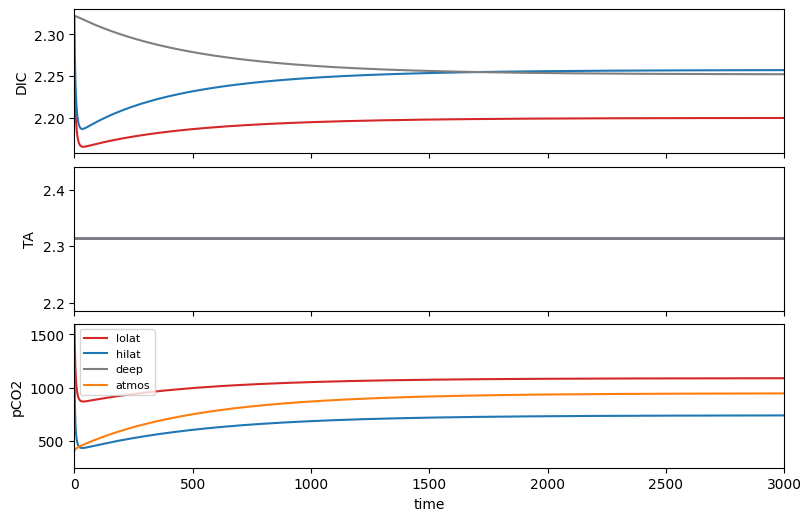

In [ ]:
from tools import plot

fig, axs = plot.boxes(time, ['DIC', 'TA', 'pCO2'], lolat, hilat, deep, atmos)

# HINT: You might want to manually change the axis limits so you can see the patterns better.
# For example, to change the y-axis in the pCO2 plot here, you could use:
#
axs[-1].set_ylim(250, 1600)

#from tools.working import ocean_model_DIC
#ref_time, ref_lolat, ref_hilat, ref_deep, ref_atmos = ocean_model_DIC(init_lolat, init_hilat, init_deep,init_atmos, 3000, 1)

#fig, axs = plot.boxes(ref_time, ['DIC', 'TA', 'pCO2'], ref_lolat, ref_hilat, ref_deep, ref_atmos)
print('hilat eq DIC',hilat['DIC'][-1])
print('lolat eq DIC',lolat['DIC'][-1])
print('deep eq DIC',deep['DIC'][-1])
print('hilat eq TA',hilat['TA'][-1])
print('lolat eq TA',lolat['TA'][-1])
print('deep eq TA',deep['TA'][-1])



> **Note**: As with the last practical, you can compare the output of your model to the reference model (this will only work if you're working on Colab, or running Python 3.10):

```python
from tools.working import ocean_model_DIC
```

hilat ss DIC 2.2570113317550047
lolat ss DIC 2.1994531193878157
deep ss DIC 2.2520595915732637
hilat ss TA 2.3134328358208953
lolat ss TA 2.3134328358208953
deep ss TA 2.3134328358208953
atmos ss carbon 1.6436932868421725e+17


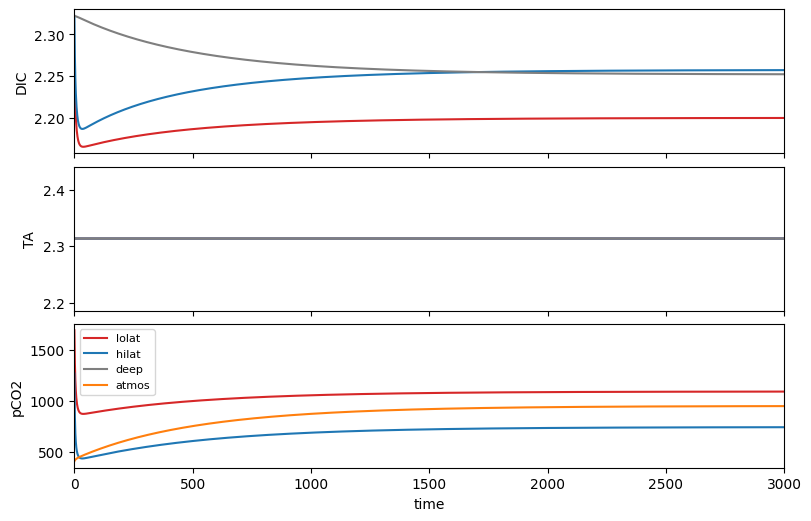

In [ ]:
from tools.working import ocean_model_DIC
ref_time, ref_lolat, ref_hilat, ref_deep, ref_atmos = ocean_model_DIC(init_lolat, init_hilat, init_deep,init_atmos, 3000, 1)
fig, axs = plot.boxes(ref_time, ['DIC', 'TA', 'pCO2'], ref_lolat, ref_hilat, ref_deep, ref_atmos)
print('hilat ss DIC',hilat['DIC'][-1])
print('lolat ss DIC',lolat['DIC'][-1])
print('deep ss DIC',deep['DIC'][-1])
print('hilat ss TA',hilat['TA'][-1])
print('lolat ss TA',lolat['TA'][-1])
print('deep ss TA',deep['TA'][-1])
print('atmos ss carbon',atmos['moles_CO2'][-1])

## Think:

1. Compare the evolution of DIC and TA. Explain the differences in their response.
2. What is the equilibrium atmospheric pCO<sub>2</sub> value in model?

In [ ]:
# use this code cell to get the final steady-state atmospheric CO2 concentration
print(ref_atmos['pCO2'][-1])

946.8279302086256


3. Look at the evolution of surface ocean and atmospheric $pCO_2$ in the model. Where is the $CO_2$ coming from? Where is it going? (you might want to play around with the axis limits so you can get a better view of what's going on in the early timesteps)
4. Calculate the total size of the DIC pool in each box (including the atmosphere). How does this compare to the distribution of DIC in the modern ocean and atmosphere, which we used to initialise the model (~38,000 PgC in the deep ocean and ~900 PgC in the surface, ~850 PgC in the atmosphere)?

In [ ]:
# Calculate the PgC in each model box and compare them.
tot_lolat = lolat['DIC'].sum() /12
tot_hilat = hilat['DIC'].sum() /12
tot_deep = deep['DIC'].sum() /12
print(tot_lolat,tot_hilat,tot_deep)

548.5667427631644 561.5449572921976 566.2195088779713


5. Once the model has reached steady state, how does ocean-atmosphere CO<sub>2</sub> exchange differ between the surface boxes? Is this consistent with patterns of CO<sub>2</sub> release/uptake in the real world?

## Experiment: Ocean Mixing and pCO2

What happens to the change in atmospheric pCO<sub>2</sub> if you double the speed of surface-deep mixing (decrease `tau_M`)? How does the change in the equilibrium value compare with the current rate of pCO<sub>2</sub> increase of ~2.3 ppm yr<sup>-1</sup>?

*Note: Always make sure you create a new copy of your initial conditions before changing them!*

In [ ]:
# create copies of your initial conditions to use in this specific scenario
mixing_init_hilat = init_hilat.copy()  # for example, this creates a copy of the initial conditions in the hilat box specific to this scenario.
mixing_init_lolat = init_lolat.copy()

# double vertical mixing speeds in both boxes
mixing_init_hilat['tau_M'] = init_lolat['tau_M'] / 2
mixing_init_lolat['tau_M'] = init_hilat['tau_M'] / 2
# run the model (remember to name the outputs with different names to avoid overwriting the previous results)
mixing_time, mixing_lolat, mixing_hilat, mixing_deep, mixing_atmos = ocean_model(mixing_init_lolat, mixing_init_hilat, init_deep, init_atmos, 3000, 1.0)

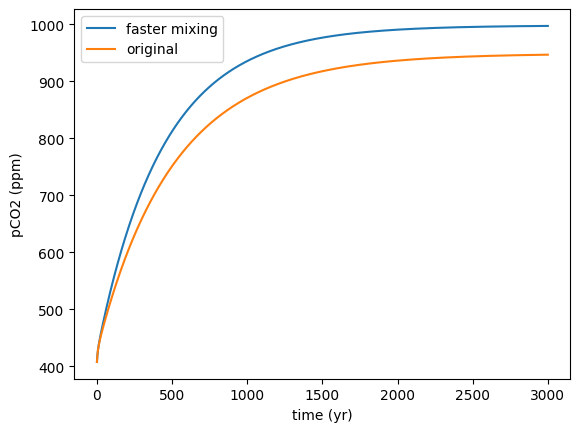

In [ ]:
# plot the evolution of pCO2 in the original model and the model with faster mixing

plt.plot(time,mixing_atmos['pCO2'],label='faster mixing')
plt.plot(time,atmos['pCO2'],label='original')
plt.xlabel('time (yr)')
plt.ylabel('pCO2 (ppm)')
plt.legend()


# Lab Report Question 4

## Experiment: CO<sub>2</sub> Emissions

Now you have a model that includes DIC speciation and the solubility pump, you can see how $CO_2$ emissions alter the patterns.
You can do this by altering the `GtC_emissions` variable in the `atmos` box.
This is an evolving variable, which allows you to change the value of the emissions in each timestep.

To help you examine the results of your experiment, you should start the model as close to equilibrium as possible. Do this by changing the initial conditions to match the steady-state DIC and TA values for each ocean box, and the amount of carbon in the atmosphere.

Conduct an experiment where you run the model for 3000 years with a 1 year timestep. Begin emitting 8 GtC per year at 500 years, then stop emitting carbon at 700 years. Create a plot showing the evolution of `DIC`, `pCO2` and `GtC_emissions` in all of the model boxes.

The CO<sub>2</sub> release can be implemented with the following code:

In [ ]:
# create a new time axis for the model containing 2000 years with a 0.5 year time step
tmax = 3000  # how many years to simulate (yr)
dt = 0.5  # the time step of the simulation (yr)
time = np.arange(0, tmax + dt, dt)  # the time axis for the model

# create an array containing GtC_emissions that contains zeros except between 800-1000 years, where 8 GtC are emitted each year.
emit_atmos = init_atmos.copy()  # create a copy of the original atmosphere input dictionary
emit_atmos['GtC_emissions'] = np.zeros(time.shape)  # creat an array to hold the emission scenario
emit_atmos['GtC_emissions'][(time > 500) & (time <= 700)] = 8.0  # set emissions to 8 GtC per year between 800-1000 years
emit_atmos['moles_CO2']=1.6436932868421725e+17

emit_hilat=init_hilat.copy()
emit_hilat['DIC']=2.2570113317550047
emit_hilat['TA']=2.3134328358208953

emit_lolat=init_lolat.copy()
emit_lolat['DIC']=2.1994531193878157
emit_lolat['TA']=2.3134328358208953

emit_deep=init_deep.copy()
emit_deep['DIC']=2.2520595915732637
emit_deep['TA']=2.3134328358208953

# run the model using this emission scenario, and create the required plot
emit_time, emit_lolat, emit_hilat, emit_deep, emit_atmos = ocean_model_DIC(emit_lolat, emit_hilat, emit_deep, emit_atmos, tmax, dt)

Make a plot of how DIC and pCO2 change in the model boxes over time, including the emission curve for reference, and discuss:

1. Where does the emitted $CO_2$ end up? Explain why this is the case.
2. Why is the steady state pCO2 at the end of the model higher than the initial steady state? What processes might reduce this back to the pre-emission value?

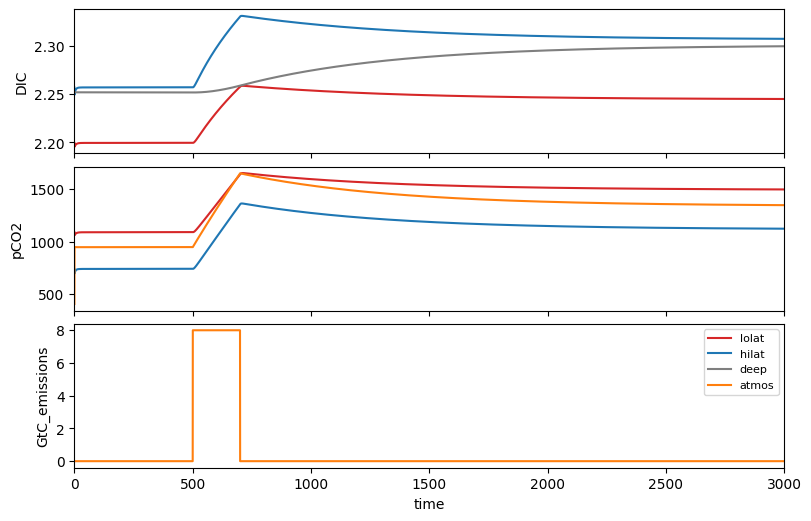

In [ ]:
# Do it here
fig, axs = plot.boxes(emit_time, ['DIC','pCO2','GtC_emissions'], emit_lolat, emit_hilat, emit_deep, emit_atmos)
